In [3]:
import pandas as pd
import numpy as np
import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac
from copy import deepcopy
from IPython import display
import functools 
import os

import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')

% load_ext autoreload
% autoreload 2
% matplotlib inline
def get_grid():
    gridpoints = np.linspace(-10, 10, 250)
    grid = []
    for y in gridpoints:
        for x in gridpoints:
            grid.append([x, y])
    return np.array(grid)

grid = get_grid()

# def scale_generator(original_generator):
#     @functools.wraps(original_generator)
#     def wrapper(x_min, x_max, dp0=0, dp1=1, *args, **kwargs):
#         or_output = original_generator(*args, **kwargs)
        
#         x_shift = x_min

#         dp = np.array((dp0, dp1))
#         x_min -= x_shift
#         x_max -= x_shift
#         for point in or_output:
#             point[:2] -= x_shift
#             point[:2] = dp[0] + (point[:2] - x_min)*(dp[1] - dp[0])/(x_max - x_min)
#             yield point
#     return wrapper

transformer = RBFSampler(n_components=100, gamma=0.075)
transformer.fit_transform(grid)

# @scale_generator
# def new_generator(generator, *args, **kwargs):

#     gen = eval(generator)(*args, **kwargs)
#     return gen

# import imageio


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


array([[-0.13591907, -0.08831071, -0.13348157, ..., -0.1316839 ,
         0.00280985, -0.12611787],
       [-0.13676841, -0.08406762, -0.13315485, ..., -0.12943013,
         0.00236474, -0.12350143],
       [-0.13754769, -0.07970411, -0.13282175, ..., -0.12695331,
         0.00191959, -0.12069355],
       ...,
       [-0.02139203,  0.13749489,  0.05277581, ..., -0.13835724,
        -0.13631783,  0.07006291],
       [-0.0245506 ,  0.13864868,  0.0536831 , ..., -0.13702282,
        -0.13643568,  0.07484419],
       [-0.02769659,  0.13960386,  0.05458782, ..., -0.13545228,
        -0.13655217,  0.07950947]])

In [4]:
# class NewPredictor(olac.pipeline.OnlinePredictor):
#     def __init__(self, verbose, transformer):
#         super().__init__()
#         self.model_hist = []
#         self.verbose = verbose
#         self.transformer = transformer
#         self.models = []
#         self.grid = self.get_grid()
        
#     def transform(self, X_train):
#         if hasattr(self.transformer, 'transform'):
#             return self.transformer.transform(X_train)
#         else:
#             return X_train
        
        
#     def train_pipeline_model(self, pipeline):
#         points = pipeline.training_queue.get_all()

#         X_train = np.vstack([np.array(p.point) for p in points])
#         y_train = np.array([p.true_label for p in points])
        
#         if self.verbose:
#             print(
#                 f'Predictor:\t{len(points)} new points available, updating ...'
#             )

#         pipeline.model.partial_fit(self.transform(X_train), y_train, classes=[0, 1])
#         try:
#             mod = deepcopy(pipeline.model)
#             self.models.append(mod)
#             if hasattr(mod, 'coef_'):
#                 self.model_hist.append((mod.coef_, mod.intercept_, mod.classes_, 
#                                         X_train, y_train))
#             elif hasattr(mod, 'coefs_'):
#                 self.model_hist.append((mod.coefs_, mod.intercepts_.copy(),
#                                         mod.classes_.copy(), mod.n_outputs_,
#                                         mod.n_layers_, mod.out_activation_,
#                                         mod._label_binarizer, X_train, y_train))
#         except AttributeError:
#             pass

#     def get_grid(self):
#         gridpoints = np.linspace(-10, 10, 250)
#         grid = []
#         for y in gridpoints:
#             for x in gridpoints:
#                 grid.append([x, y])
#         return np.array(grid)
    
#     def do_prediction(self, pipeline, x,):
#         """
#         Make a prediction. If the model has not yet been fit (burn-in phase),
#         return NaNs.
#         """
#         xt = self.transform([x])
# #         if self.verbose:
# #             print(f"Making predictions for {len(x)} points")
#         try:
#             y_pred = pipeline.model.predict(xt)

#             # certainty measure not standard across sklearn
#             # prefer predict_proba, else take decision_function
#             if hasattr(pipeline.model, 'predict_proba'):
#                 prob = pipeline.model.predict_proba(xt)
# #                 self.models.append(pipeline.model.predict_proba(self.transform(self.grid))[:,0].reshape(250,250))
#             elif hasattr(pipeline.model, 'decision_function'):
#                 prob = pipeline.model.decision_function(xt)
# #                 self.models.append(pipeline.model.decision_function(self.transform(self.grid))[:].reshape(250,250))
#             else:
#                 prob = np.nan

#         except (sklearn.exceptions.NotFittedError, AssertionError):
#             # still burning in, return NaNs.
#             y_pred = np.nan
#             prob = np.nan

#         return y_pred, prob


In [5]:
# class CertaintyLabeller(olac.pipeline.LabellerBase):
#     """A simple labeller. Once the number of points in the
#     pipeline.labelling_queue reaches a certain threshold, all points are
#     retrieved. Points are then randomly labelled with a certain probability.

#     The total number of labels purchased is tracked using an internal
#     property. This could be used for budgeting.

#     """
#     def __init__(self, threshold, prob, verbose=True):

#         """

#         Parameters
#         ----------
#         threshold: int
#             The minimum number of points to trigger a batch of labelling

#         prob: float (<= 1)
#             The probability with which each point will receive a label

#         verbose: bool
#             Whether to print output when labelling
#         """
#         super().__init__()
#         self.threshold = threshold
#         self.prob = prob
#         self.verbose = verbose

#         self.labels_bought = 0

#     def buy_labels_condition(self, pipeline: olac.pipeline.Pipeline,):
#         """Buy labels if the labelling_queue is longer than the threshold."""
#         n = pipeline.labelling_queue.qsize()
#         if n > self.threshold:
#             if self.verbose:
#                 print(
#                     f'Labeller:\tThreshold met, {n} new '
#                     'points available in queue'
#                 )
#             return True
#         else:
#             return False
    
#     def buy_labels(self, pipeline: olac.pipeline.Pipeline,):
#         """Get all the points from the labelling queue and label them with
#         some probability. """
#         labelled_points = []
#         unlabelled_points = []

#         points = pipeline.labelling_queue.get_all()
        
#         # -- filter out the nans
#         list_points = [p.to_tuple() for p in points if type(p.to_tuple()[-2]) == np.ndarray]

#         if len(list_points) == 0:
#             list_points = [p.to_tuple() for p in points]
#         else:
#             list_points = sorted(list_points, key=lambda point: point[-2][0][1], reverse=True)
        
#         try:
#             n = int(len(list_points)/2)
#             top = np.array(list_points)[:n,1]
            
# #         top10 = np.array(top10)[:, 1]
        
#             for point in points:
#                 # self.prob percent chance of being labelled
#                 if point.index in top:
#                     self.labels_bought += 1
#                     labelled_points.append(point)
#                 else:
#                     unlabelled_points.append(point)
#         except IndexError:
#             print("No points added")
            
#         if self.verbose:
#             print(f'Labeller:\tLabelled {len(labelled_points)} new points')
        
#         return labelled_points, unlabelled_points    

# class GreedyLabeller(olac.pipeline.ThresholdLabeller):
#     def buy_labels(self, pipeline):
        
#         def get_prob(point):
#             p = point.prob
#             try:
#                 return p.flatten()[-1]
#             except:
#                 return p
        
#         points = pipeline.labelling_queue.get_all()
#         points = list(sorted(
#             points, key=get_prob, reverse=True
#         ))
        
#         n_labs = int(np.round(self.prob*len(points)))
#         n_labs = max(n_labs, 1)
#         n_labs = min(n_labs, len(points))
        
#         labelled_points = points[:n_labs]
#         unlabelled_points = points[n_labs:]
        
#         if self.verbose:
#             print(f'Labeller:\tLabelled {len(labelled_points)} new points')

#         return labelled_points, unlabelled_points
    
    
# class VeryGreedyLabeller(olac.pipeline.ThresholdLabeller):
#     def buy_labels(self, pipeline):
        
#         def get_prob(point):
#             p = point.prob
#             try:
#                 return p.flatten()[-1]
#             except:
#                 return p
        
#         labelled_points = []
#         unlabelled_points = []
        
#         points = pipeline.labelling_queue.get_all()

#         for point in points:
#             prob = get_prob(point)
            
#             if np.isnan(prob):
#                 labelled_points.append(point)
#             elif prob >= 0.5:
#                 labelled_points.append(point)
#             elif np.random.uniform() < self.prob:
#                 labelled_points.append(point)
#             else:
#                 unlabelled_points.append(point)
        
#         if self.verbose:
#             print(f'Labeller:\tLabelled {len(labelled_points)} new points')

#         return labelled_points, unlabelled_points
    

# class UncertaintyLabeller(olac.pipeline.ThresholdLabeller):
#     def buy_labels(self, pipeline):
        
#         prob = hasattr(pipeline.model, 'predidct_proba')
        
#         def uncertainty(point):
#             try:
#                 p = point.prob.flatten()[-1]
#             except:
#                 p = point.prob
                
#             if prob:
#                 uncert = (p-0.5)**2
#             else:
#                 uncert = p**2
            
#             return uncert

#         points = pipeline.labelling_queue.get_all()
#         points = list(sorted(
#             points, key=uncertainty, reverse=False
#         ))
        
#         n_labs = int(np.round(self.prob*len(points)))
#         n_labs = max(n_labs, 1)
#         n_labs = min(n_labs, len(points))
        
#         labelled_points = points[:n_labs]
#         unlabelled_points = points[n_labs:]
        
#         if self.verbose:
#             print(f'Labeller:\tLabelled {len(labelled_points)} new points')

#         return labelled_points, unlabelled_points

## Testing the new labeller:

In [6]:
# data = list(new_generator(generator='olac.data_generators.satellites', x_min=-10, x_max=10, n_points=3000))
# transformer = RBFSampler(n_components=100, gamma=0.09)
# # transformer = SkewedChi2Sampler(0.1, 100)
# gridt = transformer.fit_transform(get_grid())
# sns.set_context("notebook")

# pa_pipeline = olac.pipeline.Pipeline(
#     olac.data_generators.delayed_generator(data, delay=0.05),
#     MLPClassifier((64,32,), batch_size=1, learning_rate='adaptive', early_stopping=False, 
#                     alpha=0.0003, warm_start=False),
#     NewPredictor(verbose=True, transformer=transformer),
#     CertaintyLabeller(threshold=10, prob=0.5, verbose=True))
    
# pa_train_set, pa_test_set = pa_pipeline.run()
# # plot_history(pa_pipeline, pa_train_set, save_gif=False, trans=transformer)
# # plt.close()

In [7]:
# plot_history(pa_pipeline, pa_train_set, gen_name='satellites 1% fraud',
#                     save_gif=False, trans=transformer, plot_cost=True)
# plt.close()

In [8]:
# plotter = Plotter(window=20)
# plotter.plot_history(pa_pipeline, pa_train_set, gen_name='Satellites_test',
#                      save_gif=False, trans=transformer, plot_cost=True)

In [9]:
# data = list(new_generator(generator='olac.data_generators.cluster_generator', x_min=0, x_max=1000, n_points=3000))
# transformer = RBFSampler(n_components=100, gamma=0.09)
# # transformer = SkewedChi2Sampler(0.1, 100)
# gridt = transformer.fit_transform(get_grid())
# sns.set_context("notebook")

# cg_pipeline = olac.pipeline.Pipeline(
#     olac.data_generators.delayed_generator(data, delay=0.05),
#     MLPClassifier((64,32,), batch_size=1, learning_rate='adaptive', early_stopping=False, 
#                     alpha=0.0003, warm_start=False),
#     NewPredictor(verbose=True, transformer=transformer),
#     CertaintyLabeller(threshold=10, prob=0.5, verbose=True))
    
# cg_train_set, cg_test_set = cg_pipeline.run()
# # plot_history(pa_pipeline, pa_train_set, save_gif=False, trans=transformer)
# # plt.close()

In [10]:
# plotter = olac.vis.Plotter(window=20, figsize=(15, 5))
# plotter.plot_history(cg_pipeline, cg_train_set, gen_name='popping_clusters',
#                      save_gif=True, trans=transformer, plot_cost=True, budget=100, gain_factor=3)

In [11]:
from olac.pipeline import new_generator

## Run all the pipelines

In [12]:
# transformer = RBFSampler(n_components=100, gamma=0.075)
# transformer.fit_transform(get_grid());
model = MLPClassifier((64,32,), batch_size=1, learning_rate='adaptive', early_stopping=False, 
                    alpha=0.0003, warm_start=False)
labellers = [olac.pipeline.ThresholdLabeller(threshold=10, prob=.05, verbose=False),
            ]
data_generators = [new_generator(generator='data_generators.satellites', x_min=-10, x_max=10, n_points=3000,
                                 contamination=0.3, satellite_radius=6),
                   new_generator(generator='data_generators.roving_balls', x_min=-10, x_max=10, steps=3000),
                   new_generator(generator='data_generators.cluster_generator', x_min=0, x_max=1000, n_points=3000)]

In [13]:
pipelines = []

for gen in data_generators:
    generator = list(gen)
    for labeller in labellers:
        mod_name = str(labeller.__class__).split('.')[-1].split("'")[0]
        print(mod_name)
        trans = transformer
        print(gen.__name__)
#         model = clone(mod)
        pipeline = olac.pipeline.Pipeline(data_generator=olac.data_generators.delayed_generator(generator, delay=0.15),
                                          model=clone(model),
                                          predictor=olac.pipeline.NewPredictor(verbose=False, transformer=trans),
                                          labeller=labeller)
        train_set, test_set = tqdm_notebook(pipeline.run())
        pipelines.append((pipeline, train_set, test_set))
        print('-'*20)

ThresholdLabeller
new_generator



--------------------
ThresholdLabeller
new_generator



--------------------
ThresholdLabeller
new_generator



--------------------


In [14]:
# -- run same with john's labellers

labeller_kwargs = {
    'threshold': 10,
    'prob': 0.05,
    'verbose': False,
}

# transformer = RBFSampler(n_components=100, gamma=0.075)
# transformer.fit_transform(get_grid());
model = MLPClassifier((64,32,), batch_size=1, learning_rate='adaptive', early_stopping=False, 
                    alpha=0.0003, warm_start=False)

labellers_john = [olac.labellers.UncertaintyLabeller(**labeller_kwargs),
                  olac.labellers.VeryGreedyLabeller(**labeller_kwargs),
                  olac.labellers.GreedyLabeller(**labeller_kwargs)]

data_generators = [olac.pipeline.new_generator(generator='data_generators.satellites', x_min=-10, x_max=10, n_points=3000,
                                 contamination=0.3, satellite_radius=6),
                   olac.pipeline.new_generator(generator='data_generators.roving_balls', x_min=-10, x_max=10, steps=3000),
                   olac.pipeline.new_generator(generator='data_generators.cluster_generator', x_min=0, x_max=1000, n_points=3000)]


In [15]:
pipelines_john = []

for gen in data_generators:
    generator = list(gen)
    for labeller in labellers_john:
        mod_name = str(labeller.__class__).split('.')[-1].split("'")[0]
        print(mod_name)
        trans = transformer
        print(gen.__name__)
#         model = clone(mod)
        pipeline = olac.pipeline.Pipeline(data_generator=olac.data_generators.delayed_generator(generator, delay=0.15),
                                          model=clone(model),
                                          predictor=olac.pipeline.NewPredictor(verbose=False, transformer=trans),
                                          labeller=labeller)
        train_set, test_set = tqdm_notebook(pipeline.run())
        pipelines_john.append((pipeline, train_set, test_set))
        print('-'*20)

UncertaintyLabeller
new_generator



--------------------
VeryGreedyLabeller
new_generator



--------------------
GreedyLabeller
new_generator



--------------------
UncertaintyLabeller
new_generator



--------------------
VeryGreedyLabeller
new_generator



--------------------
GreedyLabeller
new_generator



--------------------
UncertaintyLabeller
new_generator



--------------------
VeryGreedyLabeller
new_generator



--------------------
GreedyLabeller
new_generator



--------------------


In [16]:
# gen_names = ['Satellites', 'Satellites','Satellite',
#                  'Roving Balls','Roving Balls', 'Roving Balls',
#                  'Clusters', 'Clusters','Clusters',]

# lab_names =['Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',
#             'Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',
#             'Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',]

# for i, (pipeline, train_set, test_set) in enumerate(pipelines_john):       
#     plotter = olac.vis.Plotter(window=20, figsize=(20, 9))
#     plotter.plot_history(pipeline, test_set, save_gif=True, gen_name=gen_names[i]+str(i),
#                          budget=100, gain_factor=2, trans=transformer, plot_cost=True, plot_step=1,
#                         sup_title=f"DataSet: {gen_names[i]} -- {lab_names[i]}")
#     plt.show()               

In [17]:
decider = olac.cost_of_label.simple_decider
labeller_kwargs = {
    'threshold': 10,
    'decider': decider,
    'decider_kwargs':{"prob": .05}
}
bram_labeller = olac.pipeline.NaieveLabeller(**labeller_kwargs)

# transformer = RBFSampler(n_components=100, gamma=0.075)
# transformer.fit_transform(get_grid());
# transformer
model = MLPClassifier((64,32,), batch_size=1, learning_rate='adaptive', early_stopping=False, 
                    alpha=0.0003, warm_start=False)

data_generators = [olac.pipeline.new_generator(generator='data_generators.satellites', x_min=-10, x_max=10, n_points=3000,
                                 contamination=0.3, satellite_radius=6),
                   olac.pipeline.new_generator(generator='data_generators.roving_balls', x_min=-10, x_max=10, steps=3000),
                   olac.pipeline.new_generator(generator='data_generators.cluster_generator', x_min=0, x_max=1000, n_points=3000)]


In [18]:
pipelines_bram = []

for gen in tqdm_notebook(data_generators):
    generator = list(gen)

    mod_name = str(bram_labeller.__class__).split('.')[-1].split("'")[0]
    print(mod_name)
    trans = transformer
    print(gen.__name__)
#         model = clone(mod)
    pipeline = olac.pipeline.Pipeline(data_generator=olac.data_generators.delayed_generator(generator, delay=0.15),
                                      model=clone(model),
                                      predictor=olac.pipeline.NewPredictor(verbose=False, transformer=trans),
                                      labeller=bram_labeller)
    train_set, test_set = pipeline.run()
    pipelines_bram.append((pipeline, train_set, test_set))
    print('-'*20)

NaieveLabeller
new_generator
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Label

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labele

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate t

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Th

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 3 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate t

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Th

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 2 new points
Labeller:	Th

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate t

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate t

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaib

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 3 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labele

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Th

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaib

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	La

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate t

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate t

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaib

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate t

Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 finished evaluate the array
Labeller:	Labelled 1 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeler:	 evaluate the array of data in queue
Labeler:	 no investigation done
Labeler:	 finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Th

- Online vs offline
- naive vs olac >> random >> little less random >> lac (backup = something in the middle)
- make table of results 
    - acc mean + var
    - f1
    - precision
    - recall
    


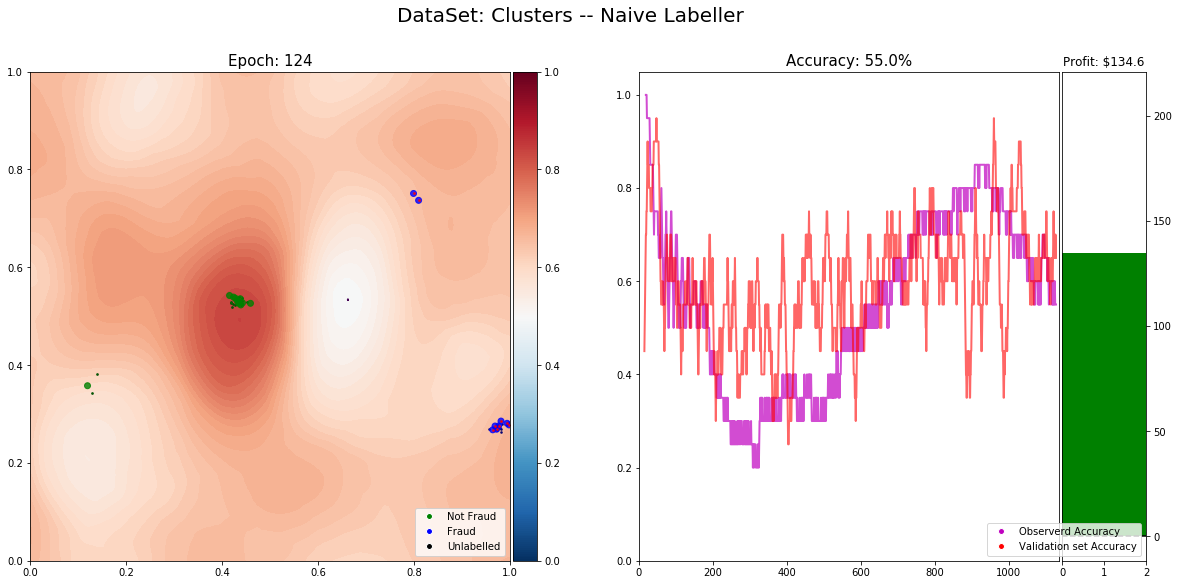

In [19]:
add = ['_n','_j','_b']
for j, P in enumerate([pipelines, pipelines_john, pipelines_bram]):


    gen_names = ['Satellites', 'Satellites','Satellite',
                     'Roving Balls','Roving Balls', 'Roving Balls',
                     'Clusters', 'Clusters','Clusters',]
    if P is pipelines_bram:
        gen_names = ['Satellites', 'Roving Balls','Clusters',]
        lab_names = ['Naive Labeller', 'Naive Labeller', 'Naive Labeller', ]
    elif P is pipelines:
        gen_names = ['Satellites', 'Roving Balls','Clusters',]
        lab_names = [ 'ThresholdLabeller', 'ThresholdLabller', 'ThresholdLabeller']
    else:
        lab_names =['Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',
                'Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',
                'Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',]


    for i, (pipeline, train_set, test_set) in enumerate(P):
        if train_set != []:
            plotter = olac.vis.Plotter(window=20, figsize=(20, 9))
            plotter.plot_history(pipeline, test_set, train_set, save_gif=True, gen_name=gen_names[i]+str(i)+add[j],
                                 budget=100, gain_factor=2, trans=transformer, plot_cost=True, plot_step=2,
                                sup_title=f"DataSet: {gen_names[i]} -- {lab_names[i]}")
            plt.show()

In [20]:
for n, P in enumerate(pipelines):
    try:
        train_df=olac.utils.queue_point_list_to_df(P[1])
    except IndexError:
        train_df = 0
    try:
        test_df = olac.utils.queue_point_list_to_df(P[2])
    except IndexError:
        test_df=0
    write_out = (P[0].predictor.model_hist, train_df, test_df)
    with open('tmp/pipelines_'+str(n), 'wb') as f:
        pickle.dump(write_out, f)

for n, P in enumerate(pipelines_john):
    try:
        train_df=olac.utils.queue_point_list_to_df(P[1])
    except IndexError:
        train_df = 0
    try:
        test_df = olac.utils.queue_point_list_to_df(P[2])
    except IndexError:
        test_df=0
    write_out = (P[0].predictor.model_hist, train_df, test_df)
    with open('tmp/pipelines_john_'+str(n), 'wb') as f:
        pickle.dump(write_out, f)

for n, P in enumerate(pipelines_bram):
    try:
        train_df=olac.utils.queue_point_list_to_df(P[1])
    except IndexError:
        train_df = 0
    try:
        test_df = olac.utils.queue_point_list_to_df(P[2])
    except IndexError:
        test_df=0
    write_out = (P[0].predictor.model_hist, train_df, test_df)
    with open('tmp/pipelines_bram_'+str(n), 'wb') as f:
        pickle.dump(write_out, f)

NameError: name 'pickle' is not defined

In [ ]:
with open('model_hist_test.pkl', 'rb') as f:
    test2 = pickle.load(f)

In [ ]:
plotter = olac.vis.Plotter(window=50, figsize=(20, 9))
plotter.plot_history(pipelines[0][0], pipelines[0][2], pipelines[0][1], save_gif=False, gen_name='test',
                     budget=100, gain_factor=2, trans=transformer, plot_cost=True, plot_step=2,
                    sup_title=f"DataSet: Test")
plt.show()

In [ ]:
df_train = olac.utils.queue_point_list_to_df(pipelines[0][1])

In [ ]:
test_cost = df_train['y_true']*10*np.random.normal(loc=2, size=len(df_train)) - (df_train['y_true'] == 0).astype(float)
# test_cost = np.array_split(test_cost.values, len(pipelines[0][0].predictor.model_hist))
test_cost = test_cost.cumsum()

In [ ]:
test_cost.min()

In [ ]:
test_cost.max()

In [ ]:
for i, c in enumerate(test_cost):
    plt.bar(x=1, height=c, )
    plt.xlim(0, 2)
    plt.ylim(test_cost.min(), test_cost.max())
    ax = plt.gca()
    ax.axhline()
    ax.tick_params(axis='y', bottom=False, right=True, left=False, top=False,
                  labelbottom=False, labelright=True, labelleft=False)
    display.clear_output(wait=True)
    time.sleep(.1)
    plt.show()

In [ ]:
for i in range(len(test_cost)):
    print(test_cost.cumsum().values[i], test_cost.values[i])

In [ ]:
import time
fake_acc = np.sin(np.linspace(50,100))*100
fake_profit = (np.sin(np.linspace(-100,50))*100)

for n, acc in enumerate(fake_acc):
    plt.axhline(c='r')
    plt.bar(x=1, height = acc, width=.3, label='Accuracy')
    plt.bar(x=2, height = fake_profit[n], width=.3, label='Profit')
    plt.xlim(0, 4)
    plt.ylim(-100,100)
    plt.legend(fontsize=20)
    plt.title("Bla lba labeller")
    display.clear_output(wait=True)
    plt.show()

    time.sleep(0.1)

In [ ]:
# gen_names = ['Satellites',# 'Satellites','Satellite',
#                  'Roving Balls',#'Roving Balls', 'Roving Balls',
#                  'Clusters',]# 'Clusters','Clusters',]

# # lab_names =['Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',
# #             'Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',
# #             'Uncertainty Labeller', 'Very Greedy Labeller', 'Greedy Labeller',]

# lab_names = ['Naive Labeller', 'Naive Labeller', 'Naive Labeller', ]
# # lab_names = ['CertaintyLabeller', 'ThresholdLabeller', 'CertaintyLabeller',
# #              'ThresholdLabller', 'CertaintyLabeller', 'ThresholdLabeller']
             

# for i, (pipeline, train_set, test_set) in enumerate(pipelines_bram):       
#     plotter = olac.vis.Plotter(window=20, figsize=(20, 9))
#     plotter.plot_history(pipeline, test_set, save_gif=True, gen_name=gen_names[i]+str(i),
#                          budget=100, gain_factor=2, trans=transformer, plot_cost=True, plot_step=2,
#                         sup_title=f"DataSet: {gen_names[i]} -- {lab_names[i]}")
#     plt.show()

In [ ]:
def get_metrics_table(pipelines, which='test', gen_names=None):
    """
    Parameters
    ----------
    pipelines: list
        constains the pipeline objects
    which: string
        test, train or both
        """
    
    for j, run in enumerate(pipelines):
        df_test = olac.utils.queue_point_list_to_df(run[2])
        df_train = olac.utils.queue_point_list_to_df(run[1])

        df_test.dropna(inplace=True); df_train.dropna(inplace=True)
        
        if which == 'test':
            df = df_test.copy()
        elif which == 'train':
            df = df_train.copy()
        elif which == 'both':
            df = df_test.append(df_train)
            df.sort_index(inplace=True)
        else:
            raise("Which can only be 'test', 'train' or 'both'")

        df_split = np.array_split(df.values, round(df.shape[0]/50))

        acc = []
        prec = []
        recall = []
        f1 = []
        TN = []
        FP = []
        FN = []
        TP = []

        for i, arr in enumerate(df_split):
            try:
                tn, fp, fn, tp = sklearn.metrics.confusion_matrix(np.vstack(arr[:,-1]).ravel(),
                                                                  np.vstack(arr[:,-4]).ravel(),
                                                                  labels=[0,1]).ravel()
            except ValueError:
                return arr, i, j
            TN.append(tn)
            FP.append(fp)
            FN.append(fn)
            TP.append(tp)
            acc.append((tp+tn)/(tn+fp+fn+tp))
            prec.append(tp/(tp+fp))
            recall.append((tp)/(tp+fn))
            f1.append(sklearn.metrics.f1_score(np.vstack(arr[:,-1]).ravel(),
                                               np.vstack(arr[:,-4]).ravel(),
                                               labels=[0,1]))

        run[0].describe(output=False)
        new_df = pd.DataFrame(np.array([acc, prec, recall, f1, TP, FP, TN, FN]).T,
                              columns=['acc','prec','recall','f1', 'tp','fp','tn','fn'])
        new_df.fillna('-')
        new_df['labeller'] = run[0].labeller_name
        if gen_names is None:
            new_df['dataset'] = run[0].data_generator_name
        else:
            new_df['dataset'] = gen_names[j]
        new_df['model'] = run[0].model_name
        
        try:
            df_final = df_final.append(new_df)
        except NameError:
            df_final = new_df
    return df_final

In [ ]:
df_pipelines = get_metrics_table(pipelines[:6], which='test', gen_names = ['satellites', 'roving_balls',
                 'clusters'])
df_john_pipelines = get_metrics_table(pipelines_john, which='test',  gen_names = ['satellites', 'satellites', 'satellites', 
                                                     'roving_balls','roving_balls', 'roving_balls',
                                                     'clusters', 'clusters','clusters',])
df_bram_pipelines = get_metrics_table(pipelines_bram, which='test',  gen_names=['satellites', 'roving_balls',
                 'clusters'])

In [ ]:
try:
    del(df_results)
except NameError:
    pass
for df in [df_pipelines.fillna(0), df_bram_pipelines.fillna(0), df_john_pipelines.fillna(0)]:

    mean_cols = ['labeller','dataset','model','acc','prec','recall','f1']
    sum_cols = ['labeller','dataset','model','tp','fp','tn','fn']
    
    df_mean = df[mean_cols].groupby(['labeller','dataset','model']).mean().reset_index()
    df_var = df[mean_cols].groupby(['labeller','dataset','model']).var().reset_index()
    
    df_sum = df[sum_cols].groupby(['labeller','dataset','model']).sum().reset_index()
    
    df_merge = df_mean.merge(df_var,
                             left_on = ['labeller','dataset','model'],
                             right_on = ['labeller','dataset','model'],
                             suffixes=('', '_var'))

    df_merge = df_merge.merge(df_sum,
                         left_on = ['labeller','dataset','model'],
                         right_on = ['labeller','dataset','model'],)
    
    df_merge = df_merge[['labeller','dataset','acc', 'acc_var',
                         'f1', 'f1_var', 'prec', 'prec_var', 'recall', 'recall_var','tp','fp','tn','fn']]
#     df_merge = df_merge.merge(df, left_on = ['labeller','dataset','model'],
#                              right_on = ['labeller','dataset','model'],how='left')
    
    try:
        df_results = df_results.append(df_merge)
    except NameError:
        df_results = df_merge
    

In [ ]:
df_pipelines = get_metrics_table(pipelines[:6], which='train', gen_names = ['satellites', 'satellites', 
                 'roving_balls','roving_balls',
                 'clusters', 'clusters',])
df_john_pipelines = get_metrics_table(pipelines_john, which='train',  gen_names = ['satellites', 'satellites', 'satellites', 
                                                     'roving_balls','roving_balls', 'roving_balls',
                                                     'clusters', 'clusters','clusters',])
df_bram_pipelines = get_metrics_table(pipelines_bram, which='train',  gen_names=['satellites','roving_balls','clusters'])

try:
    del(df_results2)
except NameError:
    pass
for df in [df_pipelines.fillna(0), df_bram_pipelines.fillna(0), df_john_pipelines.fillna(0)]:

    mean_cols = ['labeller','dataset','model','acc','prec','recall','f1']
    sum_cols = ['labeller','dataset','model','tp','fp','tn','fn']
    
    df_mean = df[mean_cols].groupby(['labeller','dataset','model']).mean().reset_index()
    df_var = df[mean_cols].groupby(['labeller','dataset','model']).var().reset_index()
    
    df_sum = df[sum_cols].groupby(['labeller','dataset','model']).sum().reset_index()
    
    df_merge = df_mean.merge(df_var,
                             left_on = ['labeller','dataset','model'],
                             right_on = ['labeller','dataset','model'],
                             suffixes=('', '_var'))

    df_merge = df_merge.merge(df_sum,
                         left_on = ['labeller','dataset','model'],
                         right_on = ['labeller','dataset','model'],)
    
    df_merge = df_merge[['labeller','dataset','acc', 'acc_var',
                         'f1', 'f1_var', 'prec', 'prec_var', 'recall', 'recall_var','tp','fp','tn','fn']]
#     df_merge = df_merge.merge(df, left_on = ['labeller','dataset','model'],
#                              right_on = ['labeller','dataset','model'],how='left')
    
    try:
        df_results2 = df_results2.append(df_merge)
    except NameError:
        df_results2 = df_merge
    
    

### TEST -  Validation

In [ ]:
df_results.round(2)

In [ ]:
df_results.groupby('dataset').mean()

In [ ]:
df_results.groupby('labeller').mean()

## Train - bought

In [ ]:
df_results2['profit'] = (df_results2['fn']+df_results2['tp']) - (df_results2['fp']+df_results2['tn'])
df_results2.round(2)

In [ ]:
df_results2.groupby('dataset').mean()

In [ ]:
df_results2.groupby('labeller').mean()

In [ ]:
sns.swarmplot(data = df_results.append(df_results2), x='recall', y='acc', hue='dataset')

In [ ]:
sns.swarmplot(data = df_results2, x='recall', y='acc', hue='labeller')